# Build the inputs required to run inference on our 91 day $\Delta$FAC model
Required inputs:
1. 1980 - 2021 temperature climatology (C)
2. 0 - 365 day average temperature (C)
3. 1980 - 2021 precipitation climatology (mm/s)
4. 0 - 365 day average precipitation (mm/s)
5. Date sine
6. Date cosine

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd
import xarray as xr
import pickle
from scipy.ndimage import gaussian_filter

from osgeo import osr
import pyproj
from pyproj import Geod
from pyproj import Proj, transform
from fiona.crs import from_epsg

# Utility functions

In [2]:
def datetime_to_date_sine_cosine(t):
    doy = t.timetuple().tm_yday
    day_sin = np.sin(doy*(2.*np.pi/365))
    day_cos = np.cos(doy*(2.*np.pi/365))
    return day_sin, day_cos

def lat_lon_to_epsg3031(tgt_lat, tgt_lon):
    # Source and target EPSG
    src = osr.SpatialReference()
    tgt = osr.SpatialReference()
    src.ImportFromEPSG(4326) # WGS-84
    tgt.ImportFromEPSG(3031) # South Polar Stereo
    
    # Define transformation
    transform = osr.CoordinateTransformation(src, tgt)
    
    # Initialize arrays
    tgt_x = np.zeros(len(tgt_lat)); tgt_x[:] = np.nan
    tgt_y = np.zeros(len(tgt_lat)); tgt_y[:] = np.nan
    
    # Perform transformation
    for j in range(0, len(tgt_x)):
        coords = transform.TransformPoint(float(tgt_lat[j]), float(tgt_lon[j]))
        tgt_x[j], tgt_y[j] = coords[0:2]
    
    return tgt_x, tgt_y

# Function to get ratio at lat/lon
def get_RF_M2_ratio(tgt_lat, tgt_lon):
    
    # Get M2 SMB at lat/lon
    M2_smb = xr.open_dataset("M2_annual-mean-SMB.nc")
    M2_smb = M2_smb['__xarray_dataarray_variable__']
    M2_smb = M2_smb.interp(lat=tgt_lat, lon=tgt_lon, method='linear').values
#     M2_smb = M2_smb.sel(lat=tgt_lat, lon=tgt_lon, method='nearest').values
        
    # Get RF at lat/lon
    tgt_x, tgt_y = lat_lon_to_epsg3031(tgt_lat, tgt_lon)
    tgt_x = xr.DataArray(tgt_x, dims="points")
    tgt_y = xr.DataArray(tgt_y, dims="points")
    M2_RF = xr.open_dataset("RF_Snow_Red_prelim.nc")
#     M2_RF = M2_RF['IS2_opt'].interp(x=tgt_x, y=tgt_y, method='linear').values
    M2_RF = M2_RF['IS2_opt'].sel(x=tgt_x, y=tgt_y, method='nearest').values

    # Get ratio
    RF_ratio = (M2_RF + M2_smb) / M2_smb
    RF_ratio = np.nan_to_num(RF_ratio, nan=1)
    
    return RF_ratio

def rolling_mean(da, ind_min, ind_max, tf_ind):
    da_ind_max = da[tf_ind - (ind_max-1):tf_ind+1, :, :].mean(dim='time')
    da_ind_min = da[tf_ind - (ind_min-1):tf_ind+1, :, :].mean(dim='time')
    da_rolling_mean = (ind_max * da_ind_max - ind_min * da_ind_min) / (ind_max - ind_min)
    return da_rolling_mean

def gaus_filter(vector, shape):
    array = np.reshape(vector, shape)
    filter_array = gaussian_filter(array, sigma=10) # Standard sigma=10.
    filter_vector = filter_array.flatten()
    return filter_vector

# First, define target information

In [3]:
# Lat/lon
# tgt_lat = np.linspace(-65, 0, 2)
# tgt_lon = np.repeat(-61.25, len(tgt_lat))
tmp = np.load("IC2_lat_lon.npy"); tgt_lat = tmp[:,0]; tgt_lon = tmp[:,1]
tgt_lat = xr.DataArray(tgt_lat, dims="points")
tgt_lon = xr.DataArray(tgt_lon, dims="points")
print(tgt_lat.shape)

# Date
tf = datetime.datetime(2021, 1, 1)
# tf = datetime.datetime(2021, 12, 31)
print(tf)

(22977621,)
2021-01-01 00:00:00


/projects/erke2265/miniconda/envs/alpine3d/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


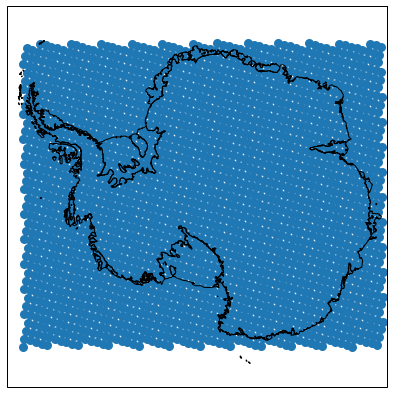

In [4]:
# Get coastlines
df = gpd.read_file("/pl/active/nasa_smb/Data/ADD_Coastline_low_res_polygon.shp")
crs_epsg = ccrs.SouthPolarStereo()
df_epsg = df.to_crs(epsg='3031')

# Generate figure 
fig, axs = plt.subplots(1, 1, subplot_kw={'projection': crs_epsg},
                        figsize=(7, 7))

# Plot sites
plt.scatter(tgt_lon[::10000], tgt_lat[::10000], linewidth=3, transform=ccrs.PlateCarree())


# Plot coastlines
axs.set_extent((-180, 180, -90, -65), ccrs.PlateCarree())
axs.add_geometries(df_epsg['geometry'], crs=crs_epsg,
                      facecolor='none', edgecolor='black')

# 1. Temperature climatology

In [5]:
# Get the shape of the src ATL15 dataset
with open('ATL15_shape.pkl', 'rb') as f:
     ATL15_shape = pickle.load(f)

M2_T2M = xr.open_mfdataset("M2_T2M_1980-2021.nc", combine='nested', concat_dim='time')
T2M_climatology = M2_T2M['T2M'].mean(dim='time')
T2M_climatology = T2M_climatology.interp(lat=tgt_lat, lon=tgt_lon, method='linear').values # Units: C
T2M_climatology = gaus_filter(T2M_climatology, ATL15_shape)

# 2. 0 - 365 day average temperature

In [6]:
tf_ind = np.where(M2_T2M['time'] == np.datetime64(tf))[0][0]
T2M_365_day = M2_T2M['T2M'][tf_ind - 364:tf_ind+1, :, :].mean(dim='time')
T2M_365_day = T2M_365_day.interp(lat=tgt_lat, lon=tgt_lon, method='linear').values # Units: C
T2M_365_day = gaus_filter(T2M_365_day, ATL15_shape)
M2_T2M.close()

# 3. 1980 - 2021 precipitation climatology (mm/hr)

In [7]:
# This is what I've tradditionally used
M2_PSUM = xr.open_dataset("M2_PSUM_1980-2021.nc")['__xarray_dataarray_variable__']
PSUM_climatology = M2_PSUM.mean(dim='time')
PSUM_climatology = PSUM_climatology.interp(lat=tgt_lat, lon=tgt_lon, method='linear').values # Units: mm/s
PSUM_climatology = gaus_filter(PSUM_climatology, ATL15_shape)

# 4. 0 - 365 91 day mean precip (mm/hr)

In [8]:
# 90 day
PSUM_90_day = M2_PSUM[tf_ind - 89:tf_ind+1, :, :].mean(dim='time')
PSUM_90_day = PSUM_90_day.interp(lat=tgt_lat, lon=tgt_lon, method='linear').values # Units: mm/s
PSUM_90_day = gaus_filter(PSUM_90_day, ATL15_shape)

# 90 day 1 year diff
tf_year_diff_ind = tf_ind - 365
PSUM_90_year_day = M2_PSUM[tf_year_diff_ind - 89:tf_year_diff_ind+1, :, :].mean(dim='time')
PSUM_90_year_day = PSUM_90_year_day.interp(lat=tgt_lat, lon=tgt_lon, method='linear').values # Units: mm/s
PSUM_90_year_day = gaus_filter(PSUM_90_year_day, ATL15_shape)

# 365 day
PSUM_365_day = M2_PSUM[tf_ind - 364:tf_ind+1, :, :].mean(dim='time')
PSUM_365_day = PSUM_365_day.interp(lat=tgt_lat, lon=tgt_lon, method='linear').values # Units: mm/s
PSUM_365_day = gaus_filter(PSUM_365_day, ATL15_shape)

# 5. - 6. Date sine and cosine

In [9]:
tf_sine, tf_cosine = datetime_to_date_sine_cosine(tf)

# Random Forest SMB Perturbation

In [10]:
def get_entire_ice_sheet_RF_M2_ratio(shape):
    
    # Get M2 SMB on RF grid
    M2_smb = xr.open_dataset("M2_annual-mean-SMB.nc")
    M2_smb = M2_smb['__xarray_dataarray_variable__']
    M2_smb_on_RF_grid = M2_smb.interp(lat=tgt_lat, lon=tgt_lon, method='linear').values
    M2_smb_on_RF_grid = np.reshape(M2_smb_on_RF_grid, shape)
        
    # Get RF
    M2_RF = np.transpose(xr.open_dataset("RF_Snow_Red_prelim.nc")['IS2_opt'].values)
    
    # Get ratio
    RF_ratio = (M2_RF + M2_smb_on_RF_grid) / M2_smb_on_RF_grid
    RF_ratio = np.nan_to_num(RF_ratio, nan=1)
    RF_ratio = RF_ratio.flatten()

    return RF_ratio

if len(tgt_lat) > 20e6:    
    print("Entire Ice Sheet")
    RF_ratio = get_entire_ice_sheet_RF_M2_ratio(ATL15_shape)    
else:
    print("Ice Sheet Region")
    RF_ratio = get_RF_M2_ratio(tgt_lat, tgt_lon)
    np.savetxt("ratio.txt", RF_ratio)
    # RF_ratio[:] = 1

Entire Ice Sheet


# Compile into an inference array `inference.txt`

In [11]:
# Features
x1 = T2M_climatology
x2 = T2M_365_day / x1
x3 = PSUM_climatology * RF_ratio
x4 = PSUM_90_day * RF_ratio / x3
x5 = PSUM_90_year_day * RF_ratio / x3
x6 = PSUM_365_day * RF_ratio / x3
# x5 = np.repeat(tf_sine, len(x1))
# x6 = np.repeat(tf_cosine, len(x1))

# Compile into array
inference = np.transpose(np.stack([x1, x2, x3, x4, x5, x6]))
inference = np.nan_to_num(inference, nan=-9999999999)
print(inference.shape)

# Save array
np.save("inference.npy", inference)

(22977621, 6)
